In [2]:
# Take your Twitter API Bearer Token and set as an Operating System environment variable via the command line.
# It is not advisable to store the token itself in the application code for security purposes

import os
os.environ['TOKEN'] = r'<BEARER-TOKEN>'

The following code on how to use Python to query the Twitter API was referenced from 

https://towardsdatascience.com/an-extensive-guide-to-collecting-tweets-from-twitter-api-v2-for-academic-research-using-python-3-518fcb71df2a

In [ ]:
!pip install bokeh
!pip install jupyter-server-proxy && jupyter serverextension enable --py jupyter-server-proxy
!jupyter labextension install @jupyterlab/server-proxy
!pip install bokeh_wordcloud2
!pip install sqlalchemy
!pip install nltk
!pip install tweet-preprocessor
!pip install wordcloud
!pip install dash
!pip install jupyter-dash
!pip install dash-bootstrap-components
!pip install -q transformers

In [28]:
# For sending GET requests from the API
import requests

# For dealing with json responses we receive from the API
import json

# For displaying the data after
import pandas as pd

# For managing the sqlite database
import sqlite3
from sqlite3 import Error

# An additional framework for managing databases using an ORM
from sqlalchemy import create_engine, Integer, JSON, Column, Sequence, select, MetaData
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

Part 1: Data stream to database.

This section of the notebook shows how you would code a script that can pull data from the Twitter API and store it into a database

In [5]:
# Functions that will be used in part one

# Gets the bearer token from the OS environment variable
def auth():
    return os.getenv('TOKEN')

# Creates the header to authorize requests to the API
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

# Creates the full URL for the API request with the desired parameters
def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

# Sends request to the specified API endpoints and returns the response
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [6]:
# Set input variables for all requests
# We will query all tweets about the Navy for the last week

bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Navy"
start_time = "2022-11-13T00:00:00.000Z"
end_time = "2022-11-18T00:00:00.000Z"
max_results = 100

In [ ]:
# Create the request URL and get the response.

url = create_url(keyword, start_time,end_time, max_results)
twitter_response = connect_to_endpoint(url[0], headers, url[1])

print(json.dumps(twitter_response, indent=4, sort_keys=True)[:200])

Now that we have some data, let's store it in a database for future use. 

The following code was referenced from
https://www.sqlitetutorial.net/sqlite-python/creating-database/

In [8]:
# Save the results to an sqlite database

def create_database(db_file):
    """ create an SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object and cursor or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        c = conn.cursor()
        return conn, c
    except Error as e:
        print(e)

    return conn

def create_table(c, create_table_sql):
    """ create a table from the create_table_sql statement
    :param c: Cursor object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql(c, sql_cmd):
    """ create a table from the create_table_sql statement
    :param c: Cursor object
    :param sql_cmd: an SQL statement
    :return:
    """
    try:
        c.execute(sql_cmd)
    except Error as e:
        print(e)

# Create our database
create_database(r"twitter.db")
print("Database created")

# Establish a connection to the database, which we can now read and write from
conn, c = create_connection(r"twitter.db")
print("Connection established")

# Initiatialize what tables are in the database

# This is our SQL statement to create a table to store our twitter data in plaintext
sql_create_twitter_table = """ CREATE TABLE IF NOT EXISTS twitter (
                                        id integer PRIMARY KEY ASC,
                                        twitter_json text NOT NULL
                                    ); """

# Create the table
create_table(c, sql_create_twitter_table)
print("Table created")

# Verify that the table was created by querying what tables are in the database
sql_tables_query = """SELECT name FROM sqlite_master WHERE type='table';"""
c.execute(sql_tables_query)
print(c.fetchall())

# Close the connection to the database
conn.close()

2.6.0
Database created
Connection established
Table created
[('twitter',)]


Now that our database is created, we can store the twitter data in the database. Instead of using raw SQL commands, we are going to practice using SQLalchemy, a python library purpose built for managing multiple types of databases in a more efficient/safe manner.

In [41]:
EntityBase = declarative_base()

# Make sure the table and column names match the table already created
class Item(EntityBase):
    __tablename__ = "twitter"
    id = Column(Integer, Sequence("item_id_seq"), primary_key=True, nullable=False)
    twitter_json = Column(JSON, nullable=True)

# Setup a database connection.
engine = create_engine("sqlite:///twitter.db")

Session = sessionmaker(bind=engine)
session = Session()

# You can create new tables using this line of code if desired
#EntityBase.metadata.create_all(engine)

# Declare a new row
first_item = Item()
first_item.twitter_json = twitter_response

# Insert it into the database
session.add(first_item)
session.commit()

# Close the session and dispose engine
session.close()
engine.dispose()

Part 2: Clean Data

We now have data streaming to a storage solution. Now we want to clean and format the data for the purposes of our application. We want to understand and visualize what people are saying about our topic of choice, so in this section we will preprocess the tweets, perform named entity recognition, sentiment analysis, and 

In [1]:
import sqlalchemy as db
import nltk
# The first time you run this cell, you may need to execute the following two lines
#nltk.download('stopwords')
#nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import json

In [14]:
# Query all data from the database using sqlalchemy

engine = db.create_engine('sqlite:///twitter.db')
connection = engine.connect()
metadata = db.MetaData()
twitter = db.Table('twitter', metadata, autoload=True, autoload_with=engine)

# Equivalent to "SELECT * FROM twitter"
query = db.select([twitter])

ResultProxy = connection.execute(query)

ResultSet = ResultProxy.fetchall()

ResultSet

[(1, '{"data": [{"text": "@savanha_2012 @Josh_Snyder11 Saw a tweet earlier that said girl Mahomes looks like she runs a captain Ds like it\\u2019s the Navy ... (108277 characters truncated) ... _id": "1593393545649557505", "oldest_id": "1593391893139755009", "result_count": 100, "next_token": "b26v89c19zqg8o3fpzhkh9u1zfboor10bhvrkgrbedlrx"}}')]

In [15]:
# Convert the results to a dataframe, convert the data column back to json from string

df = pd.DataFrame(ResultSet)
df.columns = ResultSet[0].keys()
df["twitter_json"] = df["twitter_json"].apply(json.loads) 

df.head()

,id,twitter_json
0,1,{'data': [{'text': '@savanha_2012 @Josh_Snyder...


In [16]:
# Iterate through the dataframe and pull out all of the text from the tweets and the dates

tweet_text = []
for row in df["twitter_json"]:
    for tweet in row["data"]:
        tweet_text.append((tweet["text"],tweet["created_at"]))

tweet_df = pd.DataFrame(tweet_text,columns=["tweet_text", "tweet_date"])

#tweet_df["tweet_date"] = pd.to_datetime(tweet_df["tweet_date"])

tweet_df

,tweet_text,tweet_date
0,@savanha_2012 @Josh_Snyder11 Saw a tweet earli...,2022-11-17T23:59:59.000Z
1,RT @ToddGloria: History in the making! Honored...,2022-11-17T23:59:59.000Z
2,お待たせしております、Beersシャツの予約開始です！\nカラーはBLACK、NAVY、WI...,2022-11-17T23:59:57.000Z
3,new challenge just dropped: try to make a swif...,2022-11-17T23:59:55.000Z
4,RT @USNavy: The #EOD Team assigned to Carrier ...,2022-11-17T23:59:43.000Z
...,...,...
95,"RT @larwoolf: Rock Hudson \nNovember 17, 1925 ...",2022-11-17T23:53:34.000Z
96,RT @StephenM: If President Biden cared one bit...,2022-11-17T23:53:32.000Z
97,RT @Jaejeong0807: [Free Q&amp;A session about ...,2022-11-17T23:53:28.000Z
98,@US_Navy_Ret_MD @Pazkc1971 Coast Guard has a f...,2022-11-17T23:53:27.000Z


In [17]:
# We can clean the text up a bit, so we will use a series of NLP preprocessing techniques to do so

# https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529

from nltk.tokenize import TweetTokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
import preprocessor as p
import re

# Figure out how to keep hashtags
# Perform named entity recognition

# Before we clean up the tweets entirely, we want to make sure that we are keeping the 
# named entities and hashtags intact, so we will pull those out of the tweets first

def preprocesss_tweet(input_text):
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words

    input_text = p.clean(input_text)

    input_text = input_text.replace('\d+', '')
    input_text = input_text.lower()

    input_text = [(lemmatizer.lemmatize(w)) for w in \
                                            w_tokenizer.tokenize((input_text))]
    
    input_text = remove_punctuation(input_text)
    
    stop_words = stopwords.words('english')

    new_stopwords = ["navy"]
    stop_words.extend(new_stopwords)

    filtered_sentence = [item for item in input_text if item not in stop_words]

    return filtered_sentence

tweet_df["tweet_text_clean"] = tweet_df["tweet_text"].apply(preprocesss_tweet)

tweet_df

,tweet_text,tweet_date,tweet_text_clean
0,@savanha_2012 @Josh_Snyder11 Saw a tweet earli...,2022-11-17T23:59:59.000Z,"[saw, tweet, earlier, said, girl, mahomes, loo..."
1,RT @ToddGloria: History in the making! Honored...,2022-11-17T23:59:59.000Z,"[history, making, honored, join, fellow, san, ..."
2,お待たせしております、Beersシャツの予約開始です！\nカラーはBLACK、NAVY、WI...,2022-11-17T23:59:57.000Z,"[beersblacknavywine, red, 3black, bot]"
3,new challenge just dropped: try to make a swif...,2022-11-17T23:59:55.000Z,"[new, challenge, dropped, try, make, swiftie, ..."
4,RT @USNavy: The #EOD Team assigned to Carrier ...,2022-11-17T23:59:43.000Z,"[team, assigned, carrier, strike, group, took,..."
...,...,...,...
95,"RT @larwoolf: Rock Hudson \nNovember 17, 1925 ...",2022-11-17T23:53:34.000Z,"[rock, hudson, november, october, first, scree..."
96,RT @StephenM: If President Biden cared one bit...,2022-11-17T23:53:32.000Z,"[president, biden, cared, one, bit, sovereignt..."
97,RT @Jaejeong0807: [Free Q&amp;A session about ...,2022-11-17T23:53:28.000Z,"[free, q, session, korean, military, hi, army,..."
98,@US_Navy_Ret_MD @Pazkc1971 Coast Guard has a f...,2022-11-17T23:53:27.000Z,"[coast, guard, ha, full, deck, puerto, rico, w..."


In [7]:
# Now were going to break up the words and count each occurrence of words

#words = tweet_text_clean.str.split()
word_counts = pd.value_counts(tweet_df["tweet_text_clean"].apply(pd.Series).stack())
word_counts = pd.Series(word_counts)
word_df = pd.DataFrame({'words':word_counts.index, 'weights':word_counts.values})

word_df

/tmp/ipykernel_6605/373170249.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word_counts = pd.value_counts(tweet_df["tweet_text_clean"].apply(pd.Series).stack())


,words,weights
0,u,16
1,wa,12
2,qatar,10
3,like,10
4,check,9
...,...,...
667,code,1
668,gerade,1
669,exetlos,1
670,continue,1


In [18]:
# Keep which tweets contain those words
# Change this to somehow reference the tweet dataframe, but needs to be linked in the database this way

def find_tweets(word, tweet_df):
    tweet_list = []

    for index, row in tweet_df.iterrows():
        if word in row["tweet_text_clean"]:
            tweet_list.append(row["tweet_text"])
    
    return tweet_list

word_df["source_tweets"] = word_df["words"].apply(lambda x: find_tweets(x, tweet_df))

word_df

,words,weights,source_tweets
0,u,16,[JAG to Prosecute Deep Staters In-Absentia\nTh...
1,wa,12,[@Rowan_M72 It would be pretty funny if Presid...
2,qatar,10,[RT @NurulNurAriani1: Hindutva &amp; Zionism n...
3,like,10,[@savanha_2012 @Josh_Snyder11 Saw a tweet earl...
4,check,9,[Check out this listing I just added to my #Po...
...,...,...,...
667,code,1,"[gerade die Codes der ""Navy"" des deutschen Rei..."
668,gerade,1,"[gerade die Codes der ""Navy"" des deutschen Rei..."
669,exetlos,1,"[Christopher Cleary Talks Navy Cyber Strategy,..."
670,continue,1,"[Christopher Cleary Talks Navy Cyber Strategy,..."


In [19]:
# We also will want to see sentiment analysis of what people are saying about the Navy
# Here we will use a pre-trained sentiment analysis model from Huggingface 

# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you

# Use model pretrained on tweets
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def classify_tweet(model, tokenizer, task, text):
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row)>1]

    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    results = {}

    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        #print(f"{i+1}) {l} {np.round(float(s), 4)}")
        results[f"{l}"]=np.round(float(s), 4)

    return results

In [20]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

tweet_df["sentiment"] = tweet_df['tweet_text'].apply(lambda x: classify_tweet(model, tokenizer, task, x))

tweet_df

,tweet_text,tweet_date,tweet_text_clean,sentiment
0,@savanha_2012 @Josh_Snyder11 Saw a tweet earli...,2022-11-17T23:59:59.000Z,"[saw, tweet, earlier, said, girl, mahomes, loo...","{'neutral': 0.6704, 'negative': 0.2093, 'posit..."
1,RT @ToddGloria: History in the making! Honored...,2022-11-17T23:59:59.000Z,"[history, making, honored, join, fellow, san, ...","{'positive': 0.9578, 'neutral': 0.0415, 'negat..."
2,お待たせしております、Beersシャツの予約開始です！\nカラーはBLACK、NAVY、WI...,2022-11-17T23:59:57.000Z,"[beersblacknavywine, red, 3black, bot]","{'neutral': 0.7031, 'negative': 0.256, 'positi..."
3,new challenge just dropped: try to make a swif...,2022-11-17T23:59:55.000Z,"[new, challenge, dropped, try, make, swiftie, ...","{'negative': 0.5166, 'neutral': 0.4032, 'posit..."
4,RT @USNavy: The #EOD Team assigned to Carrier ...,2022-11-17T23:59:43.000Z,"[team, assigned, carrier, strike, group, took,...","{'neutral': 0.9194, 'negative': 0.0479, 'posit..."
...,...,...,...,...
95,"RT @larwoolf: Rock Hudson \nNovember 17, 1925 ...",2022-11-17T23:53:34.000Z,"[rock, hudson, november, october, first, scree...","{'neutral': 0.9047, 'negative': 0.0605, 'posit..."
96,RT @StephenM: If President Biden cared one bit...,2022-11-17T23:53:32.000Z,"[president, biden, cared, one, bit, sovereignt...","{'negative': 0.5236, 'neutral': 0.4374, 'posit..."
97,RT @Jaejeong0807: [Free Q&amp;A session about ...,2022-11-17T23:53:28.000Z,"[free, q, session, korean, military, hi, army,...","{'neutral': 0.7131, 'positive': 0.2166, 'negat..."
98,@US_Navy_Ret_MD @Pazkc1971 Coast Guard has a f...,2022-11-17T23:53:27.000Z,"[coast, guard, ha, full, deck, puerto, rico, w...","{'neutral': 0.5943, 'negative': 0.3517, 'posit..."


Now that we have cleaned the data, we will store it all back into the database for easy access by our application and to minimize the amount of processing required for visualization

In [ ]:
# Store data in database with Pandas

# We will have two tables, one being word counts and the other being sentiment
# The storage could be more efficient, as we are storing our tweets twice in this format, but those are improvements we 
# can make in the future
# https://hackersandslackers.com/connecting-pandas-to-a-sql-database-with-sqlalchemy/

from sqlalchemy.types import Integer, Text, String, DateTime

tweet_df = tweet_df.astype(str)
word_df = word_df.astype(str)

tweet_df.to_sql(
    "tweets", 
    engine, 
    if_exists="replace", 
    index=False, 
    chunksize=500, 
    dtype={
        "tweet_text": Text,
        "tweet_date": Text,
        "tweet_text_clean": Text,
        "sentiment": Text 
        }
    )

word_df.to_sql(
    "words",
    engine,
    if_exists="replace",
    index=False,
    chunksize=500,
    dtype={
        "words": Text,
        "weights": Integer,
        "source_tweets": Text
    }
)

In [29]:
# Close the session and dispose engine
connection.close()
engine.dispose()

Part 3: Front end application

Now that we have our raw and cleaned data in a database, we can work on the web application to visualize the data.

In [34]:
# Query data we want to visualize

engine = db.create_engine('sqlite:///twitter.db')
connection = engine.connect()

tweet_df = pd.read_sql_table('tweets', engine) 
word_df = pd.read_sql_table('words', engine) 

print(tweet_df.head())
print(word_df.head())

                                          tweet_text  \
0  @savanha_2012 @Josh_Snyder11 Saw a tweet earli...   
1  RT @ToddGloria: History in the making! Honored...   
2  お待たせしております、Beersシャツの予約開始です！\nカラーはBLACK、NAVY、WI...   
3  new challenge just dropped: try to make a swif...   
4  RT @USNavy: The #EOD Team assigned to Carrier ...   

                 tweet_date  \
0  2022-11-17T23:59:59.000Z   
1  2022-11-17T23:59:59.000Z   
2  2022-11-17T23:59:57.000Z   
3  2022-11-17T23:59:55.000Z   
4  2022-11-17T23:59:43.000Z   

                                    tweet_text_clean  \
0  ['saw', 'tweet', 'earlier', 'said', 'girl', 'm...   
1  ['history', 'making', 'honored', 'join', 'fell...   
2     ['beersblacknavywine', 'red', '3black', 'bot']   
3  ['new', 'challenge', 'dropped', 'try', 'make',...   
4  ['team', 'assigned', 'carrier', 'strike', 'gro...   

                                           sentiment  
0  {'neutral': 0.6704, 'negative': 0.2093, 'posit...  
1  {'positive': 0.9578, 'neut

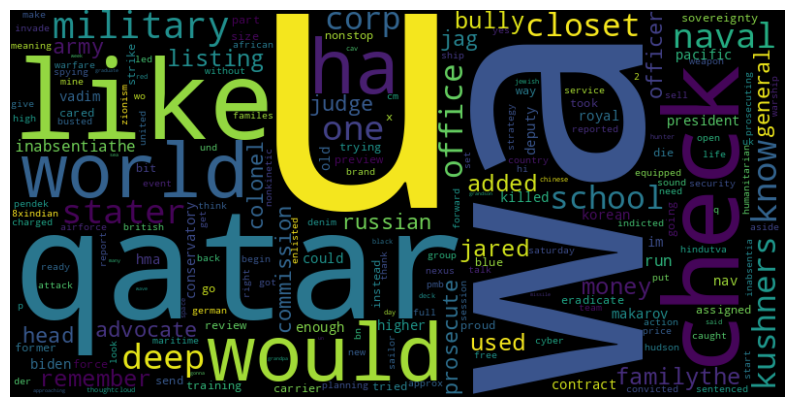

In [35]:
#This is the image we should see running in the web application

from wordcloud import WordCloud
import matplotlib.pyplot as plt

data = word_df.set_index('words').to_dict()['weights']

wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:


# This is an app built in Dash, which is built on top of Flask and Plotly.js
# It is preferable to run this from a .py file, but for ease, I am including it in the Jupyter notebook
# You will need to kill the Jupyter kernel in order to stop the process running

import dash
from dash import html
from dash import dcc
import dash_bootstrap_components as dbc
import plotly.express as px

from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
from io import BytesIO
from wordcloud import WordCloud
import base64
import dash.dependencies as dd

app = dash.Dash(__name__,external_stylesheets=[dbc.themes.LUX])
app.layout = html.Div([
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardBody([
                    html.H5('Word Cloud',className='text-center'),
                    html.Img(id="image_wc"),
                ])
            ])
        ],width={'size':12,"offset":0,'order':1},style={'padding-left' : 25,'padding-right' : 25},className='text-center'),
    ])
])

# Plot Word Cloud
def plot_wordcloud(data):
    d = {a: x for a, x in data.values}

    data = word_df.set_index('words').to_dict()['weights']

    wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)
    #wc = WordCloud(background_color='white', width=1080, height=360)
    #wc.fit_words(d)
    return wc.to_image()

# Plot bar chart of sentiment analysis
#def plot_sentiment_chart(data):

# Plot timeline of sentiment analysis
#def plot_sentiment_timeline(data):

# Plot bar chart of word count with mouseover for source tweets
#def plot_word_chart(data):

# This will keep the image updated if the data changes for a continuous stream
@app.callback(dd.Output('image_wc', 'src'), [dd.Input('image_wc', 'id')])
def make_image(b):
    img = BytesIO()
    plot_wordcloud(data=word_counts).save(img, format='PNG')
    return 'data:image/png;base64,{}'.format(base64.b64encode(img.getvalue()).decode())
   
if __name__ == "__main__":
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [20/Nov/2022 03:45:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:45:55] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:45:55] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:45:55] "GET /_favicon.ico?v=2.7.0 HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:45:56] "POST /_dash-update-component HTTP/1.1" 200 -


: 

: 

In [ ]:
# Execute this cell to create a requirements.txt to recreate the project easily

!pip install pipreqs
!pip install nbconvert
!jupyter nbconvert --output-dir="./reqs" --to script twitter-bokeh.ipynb
!cd reqs
!pipreqs --force

Congratulations! Now you should understand the basic framework of how raw data can be streamed and converted into a product for an end user. Typically this would be referred to as the "Data Lake" when done at scale. We can then preprocess, clean, and analyze the data and store it in a database in a structured manner. Typically, this would be done in a Data Warehouse. Then we can visualize the data and use it in a web application to serve as a decision aid. 

With some slight modifications, this code can be updated to run live on a cloud platform of your choice with 3 instances. Part 1 would run as an instance to stream tweets on a periodic interval to a database. Part two would then trigger to continuously clean the data and perform sentiment analysis. Part three would continuously query the database to update the live visualizations in the web application.